[2024-02-16 10:35:29,565::SequenceDataset::INFO] Loaded 167108 sequences with ec labels
[2024-02-16 10:35:29,565::SequenceDataset::INFO] Loaded 167108 sequences with ec labels
[2024-02-16 10:35:29,565::SequenceDataset::INFO] Loaded 167108 sequences with ec labels
[2024-02-16 10:35:29,567::SequenceDataset::INFO] Label level: 4; Num of labels: 1920
[2024-02-16 10:35:29,567::SequenceDataset::INFO] Label level: 4; Num of labels: 1920
[2024-02-16 10:35:29,567::SequenceDataset::INFO] Label level: 4; Num of labels: 1920
[2024-02-16 10:35:30,267::SequenceDataset::INFO] Loaded 20889 sequences with ec labels
[2024-02-16 10:35:30,267::SequenceDataset::INFO] Loaded 20889 sequences with ec labels
[2024-02-16 10:35:30,267::SequenceDataset::INFO] Loaded 20889 sequences with ec labels
[2024-02-16 10:35:30,267::SequenceDataset::INFO] Loaded 20889 sequences with ec labels
[2024-02-16 10:35:30,268::SequenceDataset::INFO] Label level: 4; Num of labels: 1920
[2024-02-16 10:35:30,268::SequenceDataset::INFO]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

test_labels: 48
wrong pred test: 93
filter minority classes: 93, test_embeddings: torch.Size([93, 2000]), train_embeddings: torch.Size([351, 2000])
wrong pred train: 96


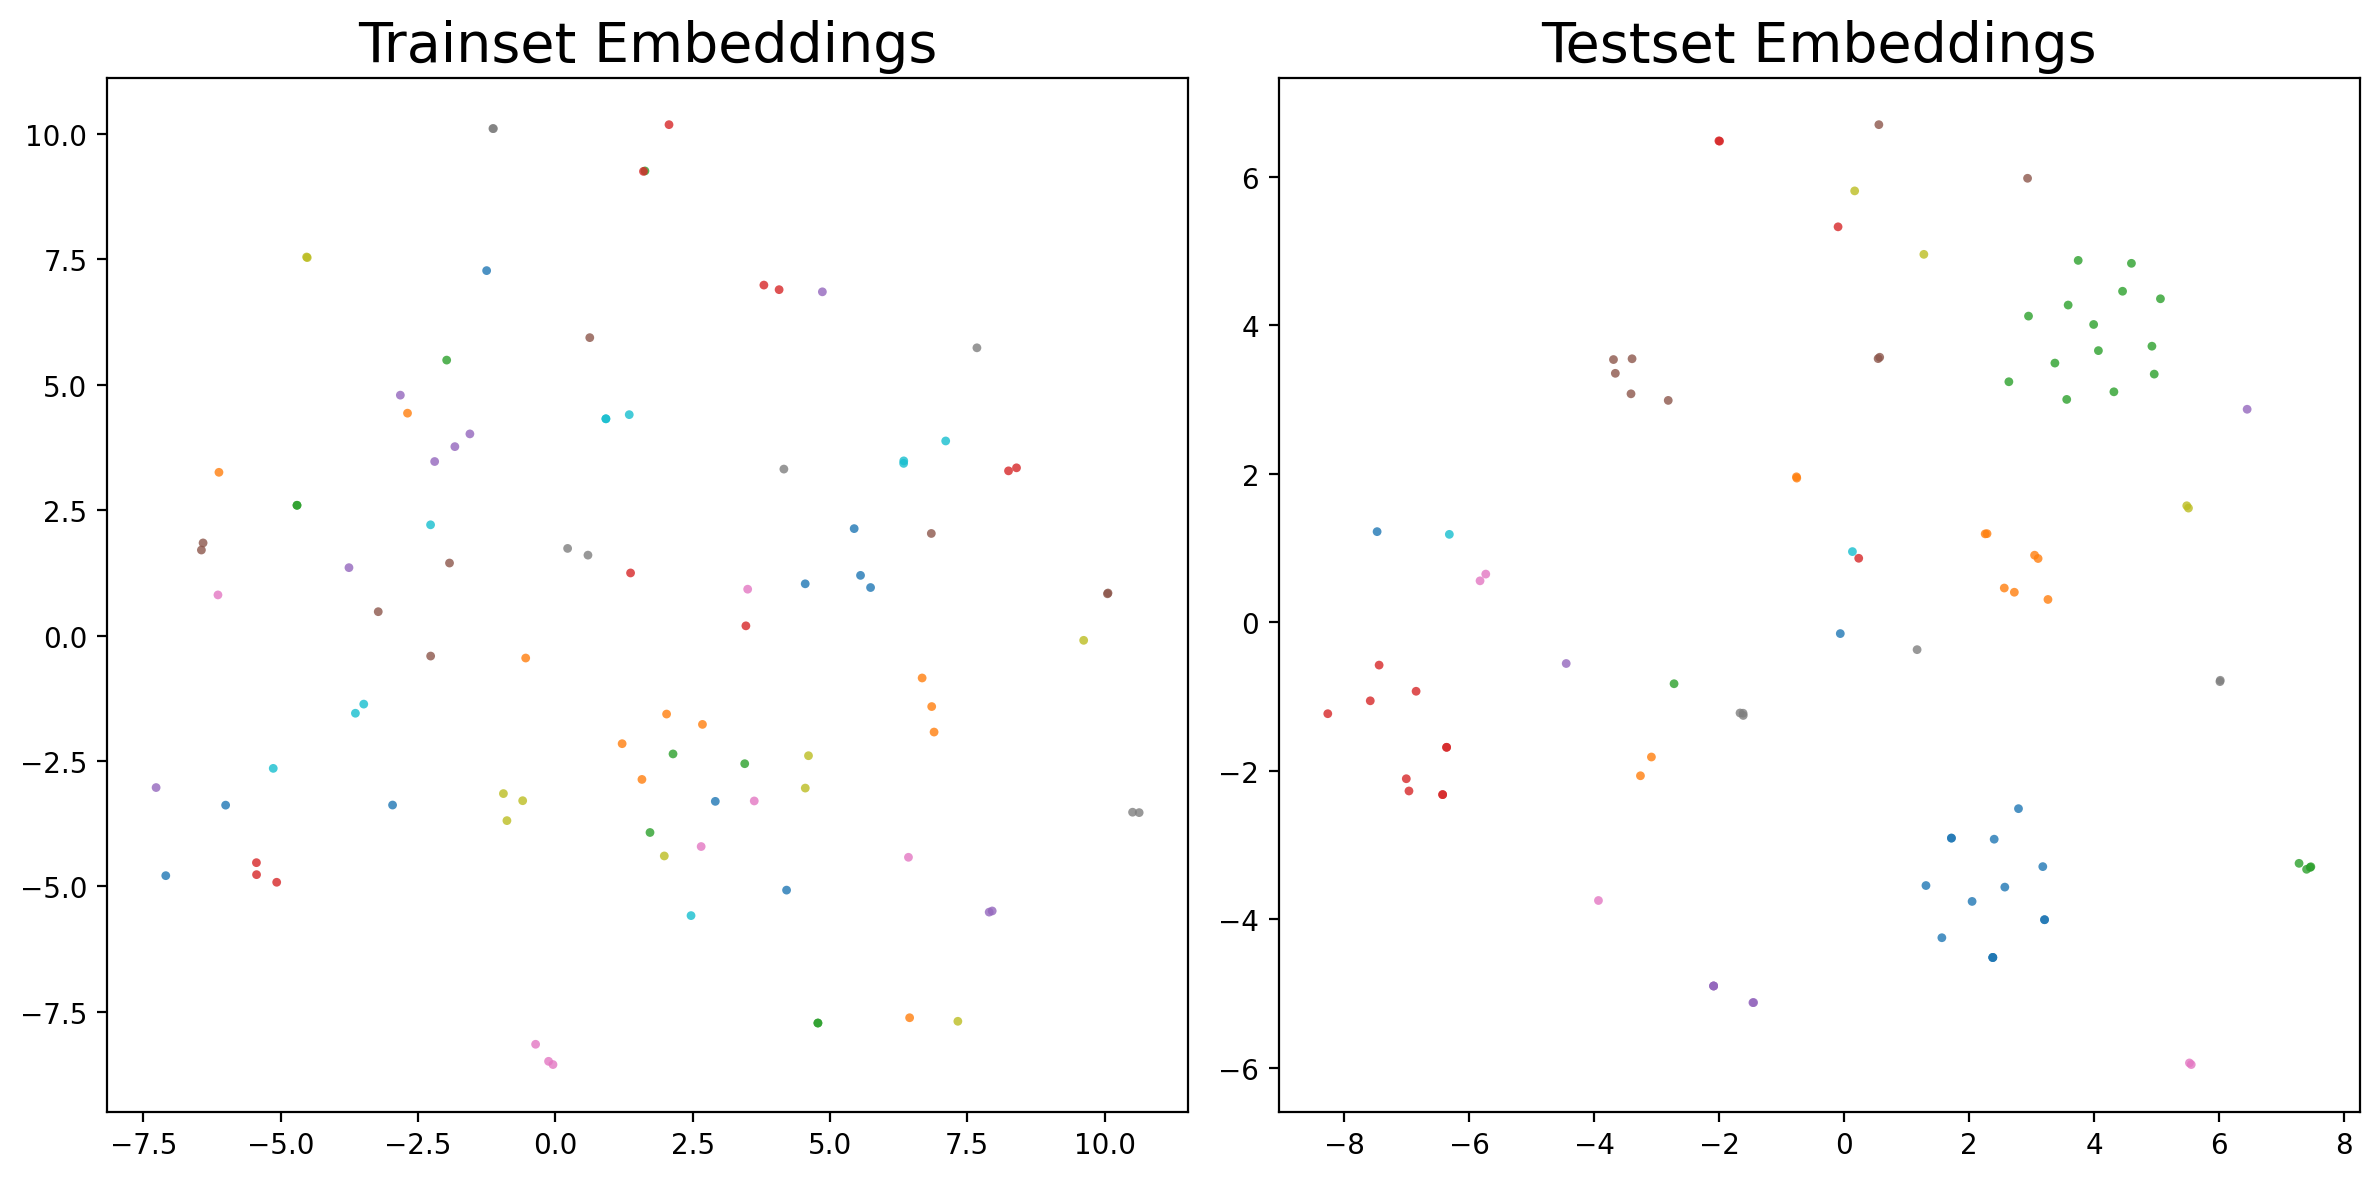

In [2]:
import sys
sys.path.append('..')
import torch
from utils import commons
from models.mlp import MLPModel
from datasets.sequence_dataset import SingleLabelSequenceDataset
import matplotlib.pyplot as plt
import numpy as np
import os, json
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.manifold import TSNE

device = 'cuda:0'

def generate_embeddings(model, dataloader, label_list):
    embeddings, labels, preds = [], [], []
    with torch.no_grad():
        for data, label in tqdm(dataloader):
            output, feature = model(data.to(device))
            embeddings.append(commons.toCPU(feature))
            pred = output.argmax(dim=1).tolist()
            pred = [label_list[i] for i in pred]
            preds.extend(pred)
            label = label.tolist()
            label = [label_list[i] for i in label]
            labels.extend(label)
    embeddings = torch.cat(embeddings, dim=0)
    assert len(embeddings) == len(labels)
    return embeddings, labels, preds

def generate_tsne(embeddings, labels, label_level=1):
    '''use TSNE to visualize the embeddings in 2D space and color with labels'''
    labels = ['.'.join(label.split('.')[:label_level]) for label in labels]
    tsne = TSNE(n_components=2, random_state=0)
    tsne_embeddings = tsne.fit_transform(embeddings)
    
    return tsne_embeddings, labels
    
def generate_umap(embeddings, labels):
    '''use UMAP to visualize the embeddings in 2D space and color with labels'''
    import umap
    umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(embeddings)
    # plot the embeddings
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=labels, palette='tab10')
    plt.show()
    
def get_ec2occurance(data_file, label_file):
    data = torch.load(data_file)
    with open(label_file, 'r') as f:
        label_list = json.load(f)
    ec2occurance = {label: 0 for label in label_list}
    for k, v in data.items():
        for label in v['ec']:
            ec2occurance[label] += 1
    
    return ec2occurance, label_list

model_dir = '../logs_new/train_mlp_single_label_CE_2024_02_15__19_16_13'
test_data_file = '../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_test.pt'
train_data_file = '../data/ec/sprot_10_1022_esm2_t33_ec_above_10_single_label_train.pt'
label_file = '../data/ec/swissprot_ec_list_above_10.json'

# dataset
trainset = SingleLabelSequenceDataset(train_data_file, label_file)
testset = SingleLabelSequenceDataset(test_data_file, label_file)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)
with open(label_file, 'r') as f:
    label_list = json.load(f)
ec2occurance, label_list = get_ec2occurance(train_data_file, label_file)

config = commons.load_config(os.path.join(model_dir, 'config.yml'))
model = globals()[config.model.model_type](config.model)
ckpt = torch.load(os.path.join(model_dir, 'checkpoints/best_checkpoints.pt'))
model.load_state_dict(ckpt)
model.eval()
model.to(device)

train_embeddings, train_labels, train_preds, = generate_embeddings(model, train_loader, label_list)
test_embeddings, test_labels, test_preds = generate_embeddings(model, test_loader, label_list)
# subsample 1/10 of the trainset
# idx = np.random.choice(len(train_embeddings), int(len(train_embeddings) / 10), replace=False)
# train_embeddings = train_embeddings[idx]
# train_labels = [train_labels[i] for i in idx]

minority_indices_test = []
for i, label in enumerate(test_labels):
    if ec2occurance[label] < 5:
        minority_indices_test.append(i)
test_embeddings = test_embeddings[minority_indices_test]
test_labels = [test_labels[i] for i in minority_indices_test]
test_preds = [test_preds[i] for i in minority_indices_test]
print(f'test_labels: {len(set(test_labels))}')
wrong_pred_indices_test = [i for i, (label, pred) in enumerate(zip(test_labels, test_preds)) if label != pred]
print(f'wrong pred test: {len(wrong_pred_indices_test)}')
test_embeddings = test_embeddings[wrong_pred_indices_test]
test_labels = [test_labels[i] for i in wrong_pred_indices_test]
test_preds = [test_preds[i] for i in wrong_pred_indices_test]

minority_indices_train = []
for i, label in enumerate(train_labels):
    if ec2occurance[label] < 5:
        minority_indices_train.append(i)
train_embeddings = train_embeddings[minority_indices_train]
train_labels = [train_labels[i] for i in minority_indices_train]
train_preds = [train_preds[i] for i in minority_indices_train]
print(f'filter minority classes: {len(test_labels)}, test_embeddings: {test_embeddings.shape}, train_embeddings: {train_embeddings.shape}')
wrong_pred_indices_train = [i for i, (label, pred) in enumerate(zip(train_labels, train_preds)) if label != pred]
print(f'wrong pred train: {len(wrong_pred_indices_train)}')
train_embeddings = train_embeddings[wrong_pred_indices_train]
train_labels = [train_labels[i] for i in wrong_pred_indices_train]
train_preds = [train_preds[i] for i in wrong_pred_indices_train]

train_tsne_embeddings, train_labels = generate_tsne(train_embeddings, train_labels, label_level=4)
test_tsne_embeddings, test_labels = generate_tsne(test_embeddings, test_labels, label_level=4)


fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
sns.scatterplot(ax=axes[0], x=train_tsne_embeddings[:, 0], y=train_tsne_embeddings[:, 1], hue=train_labels, palette='tab10', linewidth=0, alpha=0.8, s=10, legend=False)
axes[0].set_title('Trainset Embeddings', fontsize=20)

sns.scatterplot(ax=axes[1], x=test_tsne_embeddings[:, 0], y=test_tsne_embeddings[:, 1], hue=test_labels, palette='tab10', linewidth=0, alpha=0.8, s=10, legend=False)
axes[1].set_title('Testset Embeddings', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'tsne.png'), bbox_inches='tight')

In [4]:
for label in test_labels:
    print(label, ec2occurance[label])

7.6.2.7 4
4.2.1.32 2
4.2.1.32 2
7.6.2.7 4
7.6.2.7 4
2.5.1.96 3
1.3.1.12 3
4.1.2.43 3
1.3.1.12 3
4.1.2.43 3
7.6.2.7 4
3.1.3.74 2
2.1.1.198 3
6.5.1.9 3
7.6.2.7 4
4.1.2.43 3
2.5.1.96 3
1.3.1.12 3
4.2.1.32 2
4.2.1.32 2
7.6.2.7 4
2.1.1.298 1
7.6.2.7 4
7.6.2.7 4
2.3.1.75 4
7.6.2.7 4
7.6.2.7 4
4.2.1.32 2
4.2.1.32 2
7.6.2.7 4
2.10.1.1 2
1.1.1.81 2
5.4.99.18 1
1.3.1.32 4
3.1.4.58 1
4.1.2.43 3
7.6.2.7 4
2.5.1.27 4
7.6.2.7 4
4.1.2.43 3
4.1.2.43 3
4.1.2.43 3
1.3.1.12 3
7.6.2.7 4
7.6.2.7 4
4.1.2.43 3
1.3.1.12 3
2.5.1.96 3
2.3.1.75 4
3.1.3.67 4
2.4.1.141 3
1.11.1.27 2
4.2.1.79 2
1.4.3.4 1
2.10.1.1 2
5.4.99.18 1
2.1.1.346 2
1.4.3.4 1
1.4.3.4 1
2.10.1.1 2
2.10.1.1 2
1.3.1.76 3
2.7.7.75 2
5.4.99.18 1
4.2.1.32 2
4.2.1.32 2
3.1.4.58 1
4.3.1.1 2
2.4.1.141 3
5.4.99.18 1
2.1.1.298 1
2.1.1.298 1
2.5.1.96 3
2.10.1.1 2
1.3.1.12 3
2.4.1.187 2
4.1.2.43 3
1.1.1.304 3
1.1.1.304 3
2.10.1.1 2
1.3.1.12 3
4.1.2.43 3
6.5.1.9 3
1.1.1.26 4
5.3.1.30 4
7.6.2.7 4
2.1.1.298 1
3.1.4.58 1
5.3.1.30 4
2.3.1.178 2
2.1.1.198 3
2.3

False